# Tutorial 1 - Intro to neural ODE based Neural Networks
The goal of this tutorial is to get familiar with the fundamentals of the code basis and ensure it is running  
The notebook utilizes code from the package torchdiffeq and code from https://github.com/borjanG/2021-dynamical-systems

In [96]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# import pickle
# import sys
import matplotlib.pyplot as plt
import imageio
import math



# Juptyer magic: For export. Makes the plots size right for the screen
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Data preparation

Data point of X: [0.00575014 0.26743831] 
Data type X: float64

Data point of y: 1 
Data type y: float64


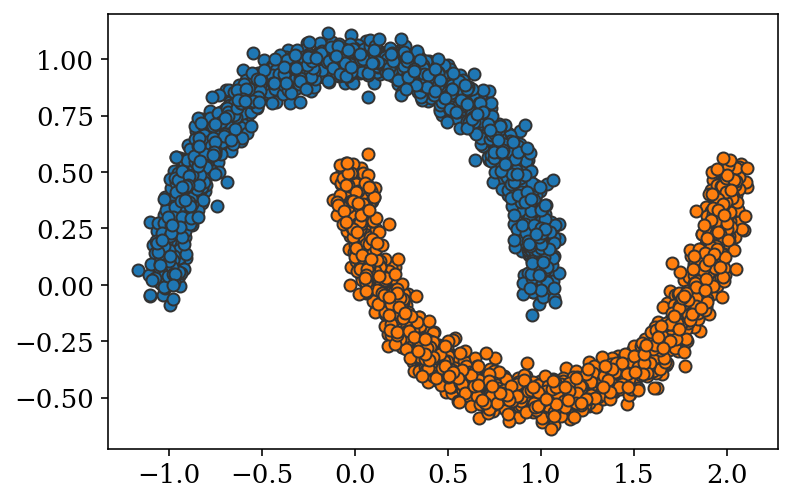

In [97]:
#We load a typical toy dataset that requires a nonlinear classification model to achieve high accuracy
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

#the noise describes how large the standard deviation of the data distribution is
noise = 0.05

#Load 3000 instances of data points
# X, y = make_circles(3000, noise=noise, factor=0.15)
X, y = make_moons(n_samples = 3000, noise = noise)



print('Data point of X:', X[0], '\nData type X:', X.dtype)
print('\nData point of y:', y[0], '\nData type y:', X.dtype)

#Visualizing the data
data_0 = X[y == 0]
data_1 = X[y == 1]
fig = plt.figure()
plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333")
plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333")
plt.show()

As typical for machine learning algorithms, we split the data into a training set and test set.  
To use the pytorch frameset, we recast the data as tensors and create Dataloaders used to conveniently load the training and test data during training and validation.

In [106]:
from torch.utils.data import DataLoader,TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2 )

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)

dataloader = DataLoader(data_line, batch_size=64, generator=g)
dataloader_viz = DataLoader(test, batch_size=128, generator = g)

In [107]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[ 0.5639,  0.9054],
        [-0.1250,  1.0541],
        [ 0.3616,  0.8847],
        [ 1.9533,  0.4074],
        [ 0.9999, -0.5234],
        [ 1.8846,  0.0454],
        [ 0.7334, -0.4971],
        [ 0.0619,  0.0154],
        [ 1.0443,  0.1091],
        [ 1.9361,  0.3480]]) tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 1])


# Model dynamics

In [108]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE


hidden_dim, data_dim = 2, 2 #for neural ODE based networks the network width is constant. In this example the input
T, num_steps = 5.0, 10  #T is the end time, num_steps are the amount of discretization steps for the ODE solver
dt = T/num_steps
turnpike = False
bound = 0.
fp = False
cross_entropy = True


non_linearity = 'relu' #'tanh'
architecture = 'bottleneck' #outside

v_steps = 5
training = True #train new network or load saved one

anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3, weight_decay=weight_decay) #weight decay parameter modifies norm
print(anode)


NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): ReLU()
      (fc1_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
        (6): Linear(in_features=2, out_features=2, bias=True)
        (7): Linear(in_features=2, out_features=2, bias=True)
        (8): Linear(in_features=2, out_features=2, bias=True)
        (9): Linear(in_features=2, out_features=2, bias=True)
      )
      (fc3_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_

In [109]:
from models.training import Trainer

trainer_anode = Trainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, 
                        turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = True)  

In [110]:
num_epochs = 100 #number of optimization runs in which the dataset is used for gradient decent
trainer_anode.train(dataloader, num_epochs)

/home/np1/staff/woehrer/FAUbox/Python/borjan dynamical.systems/models/training.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softpred = m(y_pred)



Epoch 0/38
Loss: 1.126
Accuracy: 0.406

Epoch 10/38
Loss: 1.085
Accuracy: 0.391

Epoch 20/38
Loss: 0.946
Accuracy: 0.422

Epoch 30/38
Loss: 1.049
Accuracy: 0.203
Epoch 1: 1.015

Epoch 0/38
Loss: 0.992
Accuracy: 0.328

Epoch 10/38
Loss: 0.965
Accuracy: 0.312

Epoch 20/38
Loss: 0.869
Accuracy: 0.344

Epoch 30/38
Loss: 0.957
Accuracy: 0.172
Epoch 2: 0.922

Epoch 0/38
Loss: 0.909
Accuracy: 0.281

Epoch 10/38
Loss: 0.891
Accuracy: 0.297

Epoch 20/38
Loss: 0.821
Accuracy: 0.344

Epoch 30/38
Loss: 0.892
Accuracy: 0.156
Epoch 3: 0.862

Epoch 0/38
Loss: 0.853
Accuracy: 0.297

Epoch 10/38
Loss: 0.837
Accuracy: 0.297

Epoch 20/38
Loss: 0.785
Accuracy: 0.344

Epoch 30/38
Loss: 0.842
Accuracy: 0.172
Epoch 4: 0.816

Epoch 0/38
Loss: 0.808
Accuracy: 0.312

Epoch 10/38
Loss: 0.794
Accuracy: 0.312

Epoch 20/38
Loss: 0.757
Accuracy: 0.344

Epoch 30/38
Loss: 0.801
Accuracy: 0.172
Epoch 5: 0.780

Epoch 0/38
Loss: 0.774
Accuracy: 0.328

Epoch 10/38
Loss: 0.762
Accuracy: 0.312

Epoch 20/38
Loss: 0.736
Accu

In [103]:
from plots.gifs import trajectory_gif

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif')
    break

TypeError: object of type 'type' has no len()

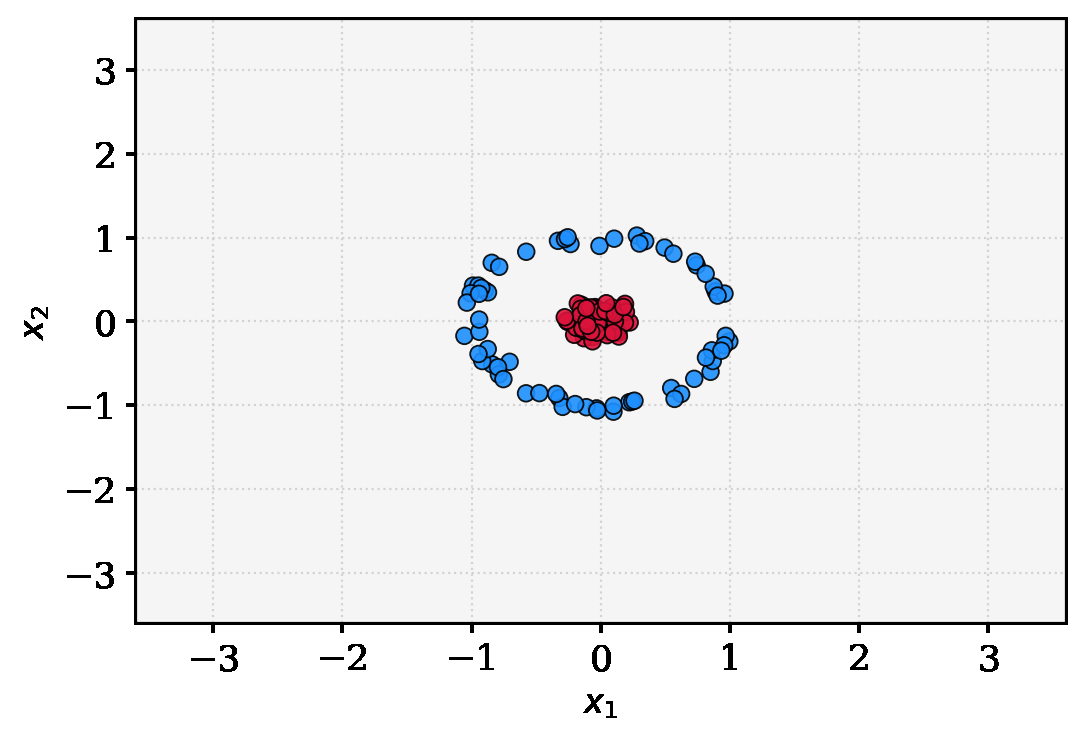

In [48]:
from IPython.display import Image
Image(filename="trajectory.gif", retina = True)

In [54]:
print("Model's state_dict:")
for param_tensor in anode.state_dict():
    print(param_tensor, "\t", anode.state_dict()[param_tensor].size())


# plt_classifier(anode, X_test, y_test, num_steps=10, save_fig = '1generalization.pdf') 


Model's state_dict:
flow.dynamics.fc1_time.0.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.0.bias 	 torch.Size([2])
flow.dynamics.fc1_time.1.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.1.bias 	 torch.Size([2])
flow.dynamics.fc1_time.2.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.2.bias 	 torch.Size([2])
flow.dynamics.fc1_time.3.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.3.bias 	 torch.Size([2])
flow.dynamics.fc1_time.4.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.4.bias 	 torch.Size([2])
flow.dynamics.fc1_time.5.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.5.bias 	 torch.Size([2])
flow.dynamics.fc1_time.6.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.6.bias 	 torch.Size([2])
flow.dynamics.fc1_time.7.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.7.bias 	 torch.Size([2])
flow.dynamics.fc1_time.8.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.8.bias 	 torch.Size([2])
flow.dynamics.fc1_time.9.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): ReLU()
      (fc1_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
        (6): Linear(in_features=2, out_features=2, bias=True)
        (7): Linear(in_features=2, out_features=2, bias=True)
        (8): Linear(in_features=2, out_features=2, bias=True)
        (9): Linear(in_features=2, out_features=2, bias=True)
      )
      (fc3_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_